# Ensemble - Voting 방식
- 서로 다른 종류의 알고리즘들을 결합하여 다수결 방식으로 최종 결과를 출력한다.

## Voting의 유형
1. **hard voting**
    - 다수의 추정기가 결정한 예측값들 중 많은 것을 선택하는 방식
    
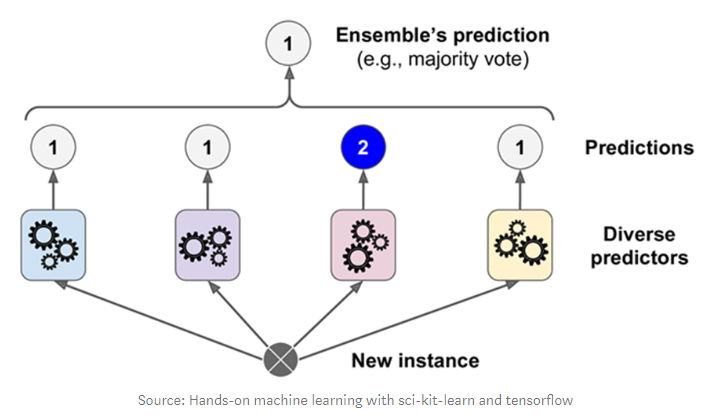  

2. **soft voting**
    - 다수의 추정기에서 각 레이블별 예측한 확률들의 평균을 내서 높은 레이블값을 결과값으로 선택하는 방식

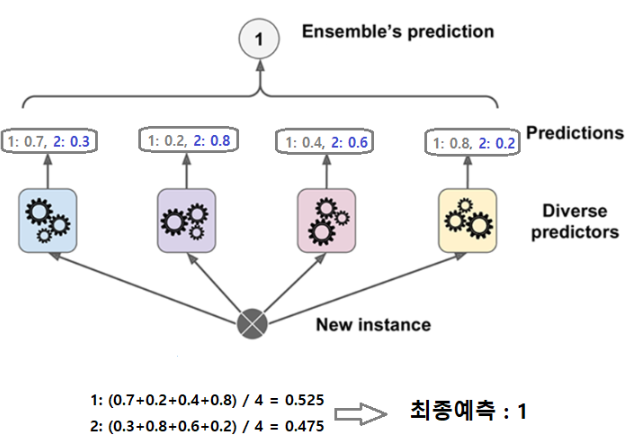

- 일반적으로 soft voting이 성능이 더 좋다.    
- Voting은 성향이 다르면서 비슷한 성능을 가진 모델들을 묶었을때 가장 좋은 성능을 낸다.

## VotingClassifier 클래스 이용
- 매개변수
    - estimators : 앙상블할 모델들 설정.  ("추정기이름", 추정기) 의 튜플을 리스트로 묶어서 전달
    - voting: voting 방식. hard(기본값), soft  지정

## 위스콘신 유방암 데이터셋으로 실습

##### import

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

/Users/han-yechan/opt/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


##### 데이터셋 로딩 및 train/test set 나누기

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

##### Data전처리
- SVM, KNN, LogisticRegression은 Feature Scaling 전처리 데이터를 사용
- Random Forest, XGBoost는 Decision Tree기반이므로 Feature Scaling이 필요없다.

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### 모델들 생성, 학습, 평가

In [4]:
# 평가함수
def print_metrics(y, pred, title=None):
    acc = accuracy_score(y, pred)
    if title:
        print(title)
    print("정확도: ", acc)

In [5]:
# 모델들 객체를 생성
svc = SVC(random_state=0) 
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
lr = LogisticRegression(max_iter=1000, random_state=0)
xgb = XGBClassifier(max_depth=2, random_state=0)

# 각 모델들을 학습
svc.fit(X_train_scaled, y_train) #Feature Scaling 된 X_train
knn.fit(X_train_scaled, y_train) #Feature Scaling 된 X_train
rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)  #Feature Scaling 된 X_train
xgb.fit(X_train, y_train)

# 평가
pred_train_svc = svc.predict(X_train_scaled)
pred_train_knn = knn.predict(X_train_scaled)
pred_train_rf = rf.predict(X_train)
pred_train_lr = lr.predict(X_train_scaled)
pred_train_xgb = xgb.predict(X_train)

pred_test_svc = svc.predict(X_test_scaled)
pred_test_knn = knn.predict(X_test_scaled)
pred_test_rf = rf.predict(X_test)
pred_test_lr = lr.predict(X_test_scaled)
pred_test_xgb = xgb.predict(X_test)

[09:40:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/han-yechan/opt/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [6]:
# trainset 평가
print_metrics(y_train, pred_train_svc, "Train SVC")
print_metrics(y_train, pred_train_knn, "Train KNN")
print_metrics(y_train, pred_train_rf, "Train RF")
print_metrics(y_train, pred_train_lr, "Train LogisticRegression")
print_metrics(y_train, pred_train_xgb, 'Train XGB')

Train SVC
정확도:  0.9929577464788732
Train KNN
정확도:  0.9788732394366197
Train RF
정확도:  0.9976525821596244
Train LogisticRegression
정확도:  0.9906103286384976
Train XGB
정확도:  1.0


In [8]:
# testset 평가
print_metrics(y_test, pred_test_svc, 'Test SVC')
print_metrics(y_test, pred_test_knn, 'Test KNN')
print_metrics(y_test, pred_test_rf, 'Test RF')
print_metrics(y_test, pred_test_lr, 'Test LogisticRegression')
print_metrics(y_test, pred_test_xgb, 'Test XGBoost')

# 1. 성능이 비슷?
# 2. 결과에 차이가 있나? (다른예측?) ==> ?(상관관계 분석)

Test SVC
정확도:  0.958041958041958
Test KNN
정확도:  0.951048951048951
Test RF
정확도:  0.9440559440559441
Test LogisticRegression
정확도:  0.958041958041958
Test XGBoost
정확도:  0.9440559440559441


### 앙상블 상관관계
- 상관관계가 높은 모델을 앙상블에 포함시키는 것은 바람직 하지 않다.
- 모델간의 상관관계가 높다는 것은 두 모델이 동일한 예측을 한다는 것이다. 같은 예측을 하는 모델은 의미가 없다. 
- Voting방식(다수결 투표방식)의 앙상블은 각각 좋은 성능을 내지만 다른 예측을 하는 다양한 모델을 모아서 하는 것이 좋다.  대부분의 모델들이 동일한 예측을 만든다면 새로운 모델을 추가해 얻는 이득이 적다.

#### 모델간의 상관관계 확인
- 각 모델의 예측 결과를 이용해 상관계수를 구한다.

In [10]:
a = np.array([1,2,3])
b = np.array([10,20,30])
c = np.array([100,200,300])

#1차원 배열들을 2차원 배열이 되도록 합치기 1축 기준으로 합칠때 c_[배열,배열,배열]
print(np.c_[a,b,c])
#1차원 배열들을 0축을 기준으로 합치기. r_[배열,배열,배열]

[[  1  10 100]
 [  2  20 200]
 [  3  30 300]]


In [11]:
import numpy as np
import pandas as pd
# Train set에 대한 예측 결과를 기준

df = pd.DataFrame(np.c_[pred_train_svc,pred_train_knn,pred_train_rf ,pred_train_lr,pred_train_xgb], 
                  columns=["SVM", "KNN", 'RandomForest', 'LogisticRegression', 'XGBoost'])
df.head()

SVM  KNN  RandomForest  LogisticRegression  XGBoost
0    1    1             1                   1        1
1    0    0             0                   0        0
2    1    1             1                   1        1
3    1    1             1                   1        1
4    1    1             1                   1        1

In [16]:
#각 feature 간의 상관계수 계산 - df.corr()
df.corr()

SVM       KNN  RandomForest  LogisticRegression  \
SVM                 1.000000  0.969819      0.989940            0.994976   
KNN                 0.969819  1.000000      0.959758            0.974829   
RandomForest        0.989940  0.959758      1.000000            0.984902   
LogisticRegression  0.994976  0.974829      0.984902            1.000000   
XGBoost             0.984941  0.954799      0.994989            0.979929   

                     XGBoost  
SVM                 0.984941  
KNN                 0.954799  
RandomForest        0.994989  
LogisticRegression  0.979929  
XGBoost             1.000000

Train set 결과 성능이 가장 좋았던 XGBoost를 기준으로 상관관계가 낮은 KNN, LogisticRegression을 선택해서 Voting 한다.

##### VotingClassifier로 앙상블

In [17]:
# 앙상블할 모델들 리스트 
estimators = [
    ('knn', knn),
    ('xgb', xgb), 
    ('logistic regression', lr)
]

###### hard voting

In [18]:
voting = VotingClassifier(estimators) #hard voting

In [19]:
voting.fit(X_train_scaled, y_train)  #각 모델을 학습시킨다.

[10:27:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/han-yechan/opt/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=2,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                    

In [20]:
pred_train = voting.predict(X_train_scaled)
pred_test = voting.predict(X_test_scaled)

print_metrics(y_train, pred_train)
print_metrics(y_test, pred_test)

정확도:  0.9906103286384976
정확도:  0.958041958041958


###### soft voting

In [21]:
voting = VotingClassifier(estimators, voting='soft') #soft voting (확률 평균으로 결과를 예측)
voting.fit(X_train_scaled, y_train)

[10:27:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/han-yechan/opt/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=2,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                    

In [22]:
pred_train = voting.predict(X_train_scaled)
pred_test = voting.predict(X_test_scaled)

print_metrics(y_train, pred_train)
print_metrics(y_test, pred_test)

정확도:  0.9953051643192489
정확도:  0.965034965034965


##### Pipeline을 이용해 데이터전처리와 모델 묶어서 처리
- KNN, LogisticRegression: Feature Scaling이 필요 => Pipeline
- XGBoost:  Feature Scaling 불필요

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
# 파이프라인 생성
order_knn = [
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]
order_lr = [
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=1000))
]

knn_pl = Pipeline(order_knn)  # make_pipeline(SS(), KNN())
lr_pl = Pipeline(order_lr)

# XGBoost
xgb = XGBClassifier(max_depth=2, random_state=0)

estimators = [
    ('knn', knn_pl),
    ('logistic_regression', lr_pl),
    ('xgb', xgb)
]
voting = VotingClassifier(estimators, voting='soft')

In [ ]:
voting.fit(X_train, y_train)

In [ ]:
print_metrics(y_train, voting.predict(X_train))
print_metrics(y_test, voting.predict(X_test))